# Customer Lifetime Value Prediction Using BG/NBD Model and Gamma-Gamma Model

This project consists of 4 parts

1. Data Preparation  
1.1. The Relative Paths for each folder.  
1.2. Set the settings and determine the split point for test and train the data.  
1.3. Visualization.  

2. Data Visualization (Plots and Tables)  

3. Model Fitting and Predictions  

4. Results


## Part 1. Data Preperation


### 1.1 The Relative Paths for each folder
The chunk below creates a relative path. Meaning any user who can access the files where this project located, can run the project withouh changing anything. 

In [149]:
from pathlib import Path
import pandas as pd
from IPython.display import display



PROJECT_ROOT = Path.cwd() #to create a relative path
print("Project Root is:") 
print(PROJECT_ROOT)
RAW_DIR = PROJECT_ROOT / "Raw_Data" #location of Raw_DIR 
Clean_DIR = PROJECT_ROOT/"Clean_Data"
Ana_DIR = PROJECT_ROOT/"Analysis_Data"
Plt_DIR = PROJECT_ROOT/"Plots"
Table_DIR = PROJECT_ROOT/"Tables"
print("")

print("Other paths are: \n",
      RAW_DIR,
      Clean_DIR,
      Ana_DIR,
      Plt_DIR,
      Table_DIR)



Project Root is:
/Users/mertbasaran/Desktop/Project_1

Other paths are: 
 /Users/mertbasaran/Desktop/Project_1/Raw_Data /Users/mertbasaran/Desktop/Project_1/Clean_Data /Users/mertbasaran/Desktop/Project_1/Analysis_Data /Users/mertbasaran/Desktop/Project_1/Plots /Users/mertbasaran/Desktop/Project_1/Tables


### 1.2 Set the settings and determine the split point for test and train the data
 The Codes below changes the display settings and splits the date into two parts: Train and Test. 75% of the time period has been choosen as the train data and remaining 25% of the data will be utilized as test. 

In [150]:
pd.set_option('display.max_rows', 50) #Shows 50 rows 
pd.set_option('display.max_columns', None)#Better display
Raw_csv = RAW_DIR/"df.csv"
df = pd.read_csv(Raw_csv) #Reads the data frame
df.head(10)
df.rename(columns={"Customer ID":"ID"}, inplace=True)#Chance Customer ID column with ID
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"]) #Makes InvoiceDate type(date64)
df["InvoiceDate"] = df["InvoiceDate"].dt.floor("D") # Set hours to "0"


e = df["InvoiceDate"].max() # e stands for end date of whole period
s = df["InvoiceDate"].min() #s stands for start date of whole period
print("Start Date is:",s) 
print("End Date is:",e )

num_days = (e - s).days # Number of days in whole period

print("There are",num_days,"days") 

train_days = num_days-90 #We take 75 percent of the date to train and we are going to use it predict remaning 25 percent

print("train period is",train_days,"days")
split_date = s + pd.Timedelta(days=train_days)
print("Data will be splitted after:",split_date) 
Prediction_days = num_days - train_days
print("Predicted Number of days are",Prediction_days)


train_df_1 = df[df["InvoiceDate"] <= split_date]
test_df_1  = df[df["InvoiceDate"] >  split_date]


Start Date is: 2009-12-01 00:00:00
End Date is: 2011-12-09 00:00:00
There are 738 days
train period is 648 days
Data will be splitted after: 2011-09-10 00:00:00
Predicted Number of days are 90


### 1.3 Some further data cleaning and wrangling.
CustomerID is very crutial for this project. We need to identify number of transactions per customer to run the model. Therefore, the rows with NA values of CustomerID has been removed from the data. Moreover, In the dataset desctription it is stated that if an InvoiceNo starts with letter "c", than it is a cancelled order. Such orders is deleted from the dataset.

In [151]:
#Removing the NA Customer IDs
print("number of rows :",df.shape[0])
df.rename(columns={"Customer ID":"ID"}, inplace=True)#Chance Customer ID column with ID
df = df[~df["StockCode"].astype(str).str.isalpha()].copy() #It removes the string values in StockCode such as DOT, Manual these are not transactions
df = df[~df["ID"].isna()]
print("NA values of ID is",df["ID"].isna().sum())

print("NA rows by column names:")
print(df.isna().sum())

print("The column names are:",df.columns)
print("clean data control")
clean_df = df


#In the description it is stated that Invoice No starts with letter "c" means the order is canceled.
#In this chunk such orders has been removed from dataset as well
canceled_boolean = clean_df['Invoice'].str.startswith("C",na=False)#This gives a boolean value which outputs TRUE if an Invoice starts with letter "C"
num_cancel = canceled_boolean.sum()

print("Number of cancelled orders is:", num_cancel)

canceled_df = clean_df[canceled_boolean]#Only cancelled dataframe
#display(canceled_df.head(10))

clean_df1 = clean_df[~canceled_boolean]#Dataframe that cancelled orders removed
#display(clean_df1.head(10))

c_df1_dir = Clean_DIR/"clean_df1.csv"
clean_df1.to_csv(c_df1_dir,index=False)

number of rows : 1067371
NA values of ID is 0
NA rows by column names:
Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
ID             0
Country        0
dtype: int64
The column names are: Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'ID', 'Country'],
      dtype='object')
clean data control
Number of cancelled orders is: 17949


Below, is the control if there is any inconsistency in data wrangling. 

In [152]:
#Checking if cancelled data correctly removed
print("Total rows:", len(clean_df))
print("Cancelled:", len(canceled_df))
print("Without Cancelled:", len(clean_df1))
print("Check:", len(canceled_df) + len(clean_df1) == len(clean_df))

print("Control 1",sum(clean_df1["Quantity"] < 0) == 0) #After Cancelled Orders are removed there must not be negative quantity
print("Control 2",sum(clean_df["Quantity"] < 0)!=0)#Before Cancelled Orders are removed there must be negative quantity s

Total rows: 820944
Cancelled: 17949
Without Cancelled: 802995
Check: True
Control 1 True
Control 2 True


In [153]:
#Dublicate values 
print(clean_df1.columns)
dupes = clean_df1[clean_df1.duplicated(subset= ['Invoice','ID','StockCode'],keep=False)] #Duplicated values by Invoice, Stock Code and Customor ID

dupes.sort_values(['Invoice','StockCode'], ascending=[True, False]).head(2)
#We can see here that There are some items appear more than 2 times in same Invoice. We can sum the quantities of the same items in same invoice and can have a cleaner data


Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'ID', 'Country'],
      dtype='object')


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,ID,Country
289,489488,22125,UNION JACK HOT WATER BOTTLE,2,2009-12-01,5.95,17238.0,United Kingdom
299,489488,22125,UNION JACK HOT WATER BOTTLE,1,2009-12-01,5.95,17238.0,United Kingdom


There are some items appear more than 2 times in same Invoice(ie first two rows above). We will sum the quantities of the same items in same invoice to have a cleaner data.

In [154]:
#Dublicate values 
print(clean_df1.columns)
dupes = clean_df1[clean_df1.duplicated(subset= ['Invoice','ID','StockCode'],keep=False)] #Duplicated values by Invoice, Stock Code and Customor ID

dupes.sort_values(['Invoice','StockCode'], ascending=[True, False]).head(35)
#We can see here that There are some items appear more than 2 times in same Invoice. We can sum the quantities of the same items in same invoice and can have a cleaner data

clean_df2 = clean_df1.groupby(["Invoice","StockCode","ID"], as_index=False).agg(   
                                                                                        Invoice=("Invoice","first"),
                                                                                        Quantity = ("Quantity","sum"),
                                                                                        Price = ("Price","first"),
                                                                                        InvoiceDate = ("InvoiceDate","first"),
                                                                                        StockCode = ("StockCode","first"),
                                                                                        Description = ("Description","first"),
                                                                                        ID = ("ID","first"),                                                                                                                                                     
                                                                                        Country = ("Country","first"),
                                                                                                                     
                                                                                                                       )  #Groups the cleandf1 by Customer ID, Invoice and Stock Code
                                                                                                                          #Than 1-) sums the Quantities Collumn in the grupus
                                                                                                                          #and  2-) Keeps the first observation of other Columns 
                                                                                                                                                                                                          
#Control
dupes1 = clean_df2[clean_df2.duplicated(subset= ['Invoice',"ID",'StockCode'],keep=False)] #Duplicated values by Invoice, Stock Code and Customor ID
dupes1.sort_values(['Invoice','StockCode'], ascending=[True, False]).head(35)#No dupes observable meaning cleandf2 is generated as we wanted          
clean_df2.head(10)


c_df2_dir = Clean_DIR/"clean_df2.csv"
clean_df2.to_csv(c_df2_dir, index=False)

clean_df2.columns

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'ID', 'Country'],
      dtype='object')


Index(['Invoice', 'Quantity', 'Price', 'InvoiceDate', 'StockCode',
       'Description', 'ID', 'Country'],
      dtype='object')

Below a new column named Total is created. Total column is obtained by multiplying quantity and price. In this the data also splitted into two parts as stated previously. Data is splitted after 2011-06-08. The data which will be concern of this projects ends on 2011-06.08. After this period the train data covers the period between 2011.06.09 to 2011.12.09.

In [155]:
clean_df2["Total"] = clean_df2["Quantity"]*clean_df2["Price"]
clean_df2.columns

clean_df2 = clean_df2[clean_df2["InvoiceDate"]<=split_date] #We split to date two parts as train and test from now on We will be using train part
#clean_df2["Variety"] = clean_df2.groupby(["Invoice"],as_index=False)["StockCode"].transform("nunique") #Added the purchase of the number of different items to all rows per customer
clean_df3 = clean_df2.groupby(["Invoice","InvoiceDate"],as_index=False).agg(
                                                                            ID = ("ID","first"),
                                                                            Total= ("Total","sum"),
                                                                            #Variety = ("Variety","first"),
                                                                            ) #Now Row represents each purchase. 


c_df3_dir = Clean_DIR/"clean_df3.csv"
clean_df3.to_csv(c_df3_dir, index=False)

#display(clean_df3.head(10))


## Part 2. Data Visualization

### 1. Plots 
#### 1.1. Plot of the Transaction Value per day through the train period

In [156]:

##clean_df3["PurchNum"] = clean_df3.groupby(["InvoiceDate"],as_index=False)["Invoice"].transform("nunique")#Adds  Purchase Numbers to the data frame for each day

plot_df = clean_df3.groupby("InvoiceDate",as_index=False).agg(
                                               Total = ("Total","sum"),
                                              #InvoiceDate = ("InvoiceDate","first"),
                                              ) #Aggregate total purchase number for eachday.  


#display(clean_df3.head(10))
#display(plot_df.tail(10))

<Figure size 1800x800 with 0 Axes>

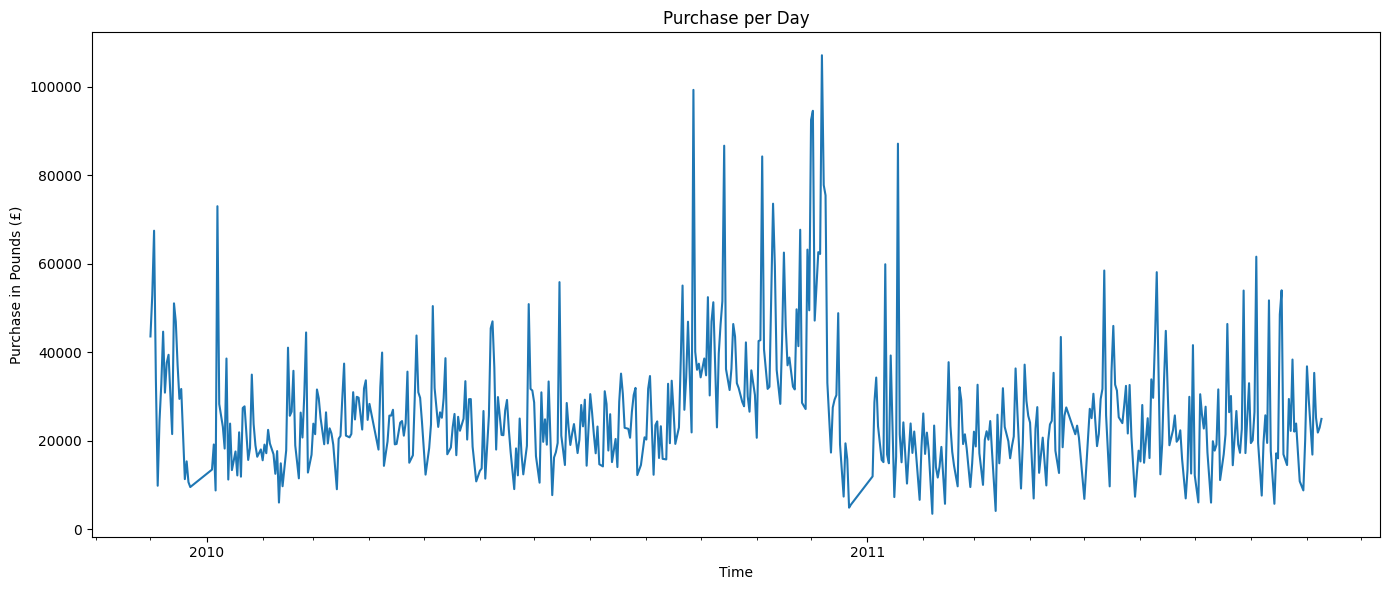

In [157]:
#Plot1
plot1_dir = Plt_DIR/"Purchase Per Day.pdf"
#Visulisation Purchase per day in monetary Unit
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.dates as mdates

plt.figure(figsize=(18, 8))

plot_df["InvoiceDate"] = pd.to_datetime(plot_df["InvoiceDate"])

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(plot_df["InvoiceDate"], plot_df["Total"])

ax.set_xlabel("Time")
ax.set_ylabel("Purchase in Pounds (£)")
ax.set_title("Purchase per Day")

ax.xaxis.set_major_locator(mdates.YearLocator())          # One tick for each year
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))  # Takes only the years (which has been ticked on previous line)
ax.xaxis.set_minor_locator(mdates.MonthLocator())

plt.tight_layout()
plt.savefig(plot1_dir,dpi=300,bbox_inches="tight")
plt.show()

#### 1.2 Frequency table of Transactions 


In [158]:
#Now we will filter the data per customer by purchase number

clean_df3["Transaction"]= clean_df3.groupby(["ID"],as_index=False)["Invoice"].transform("nunique")#Writes Transaction number of each Customer as a new column
#However the data is ordered by Invoices therefore, if a customer make more than one purchase they appear more than one in the data
#We need to drop the duplicates before checking the frequency table of transactions. 
#display(clean_df3.sort_values("CustomerID").head(10))
#display(clean_df3.sort_values("CustomerID").tail(10))
#display(clean_df3.sort_values("Transaction").head(10))
#display(clean_df3.sort_values("Transaction").tail(10))


cust_tx = clean_df3[["ID", "Transaction"]].drop_duplicates() #Now there is one row per customer. 

#display(cust_tx.head(10)) # First table below



freq_table = (                   #Gives the freqency table of transactions 
    cust_tx["Transaction"]
      .value_counts(dropna=False)
      .sort_index()
      .reset_index()
)

freq_table.columns = ["Transaction", "Freq"]
#freq_table #Second table below



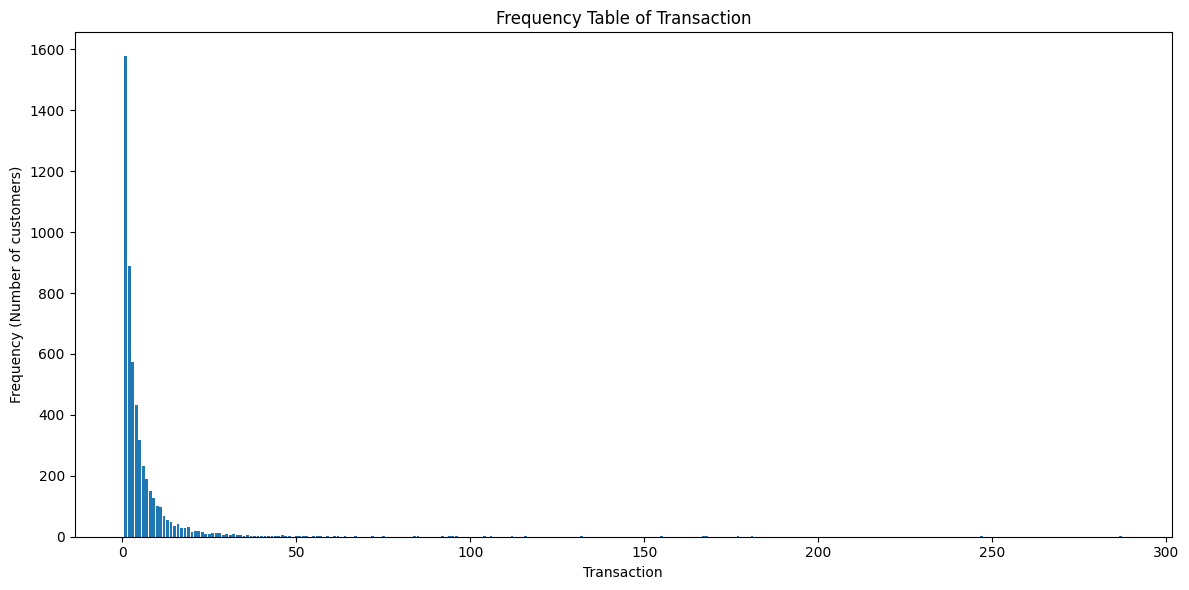

In [159]:
#Plot2
Plot2_dir = Plt_DIR/"Freqency_Tab_of_Transaction.pdf"

import matplotlib.pyplot as plt


freq = cust_tx["Transaction"].value_counts().sort_index()

plt.figure(figsize=(12, 6))
plt.bar(freq.index, freq.values)
plt.xlabel("Transaction")
plt.ylabel("Frequency (Number of customers)")
plt.title("Frequency Table of Transaction")
plt.tight_layout()
plt.savefig(Plot2_dir, dpi=300, bbox_inches="tight")
plt.show()

## Part 3. BG/NBD Model for Predicting P(Alive) and Transactions Gamma-Gamma model for predicting Total Spending per Customer

### 3.1 Data wranglings to prepare data in way that its sutiable with lifevalues package. 


At this part Frequency, Recency, Age variables are created for each customer.

They defined;
Frequency: Number of transaction made by an individual after their first purchase.   
Recency: Number of the days between first and last transaction of an individual.    
Age: Number of the days between the first transaction and the last date of the available data.    

In [160]:
###Now we can proceed with the analysis all the data wranglings after this point concerns the analysis
###We will use lifetime package
###This package models the pace of purchases of the customers globally and individually.
###Global pace of puchases is modeled with 2 paramater gamma distribution.
###Individual pace of purchases is modeled with poisson process. The parameter of poisson distribution is distributed with gamma(a,b) using the previous step
###Therefore posterior density of lambda(parameter of poisson distribution) is Negative binomial (NBD)
###Global dropout rate is modelled with Beta(x,y)(B) and Individual dropout rate is modelled with geometric distribution(G). (BG)
###We will use BG/NBD to model CLV.
###The required information from the data:
##a-)Frequency: Number of transaction made by an individual after their first purchase 
##b-)Recency: Number of the days between first and last transaction of an individual
##c-)Age: Number of the days between the first transaction and the last date of the available data 

##In addition d-)A_Total_S: Avarage Total spending of each Customer in given period.


clean_df3.head(10)

#FIRST VARIABLE FREQUENCY 
clean_df3["Freq"] = clean_df3["Transaction"] - (1) #We define first object of the package. Freq is the count of transactions after first transaction made

max_transaction = max(clean_df3["Transaction"])
min_transaction = min(clean_df3["Transaction"])
max_Freq = max(clean_df3["Freq"])
min_Freq = min(clean_df3["Freq"])

Start_Date = min(clean_df3["InvoiceDate"])
End_Date = max(clean_df3["InvoiceDate"])

print("End Date:",End_Date)
print("Start Date:",Start_Date)
print("Min Transactions:",min_transaction)
print("Max Transactions:",max_transaction)
print("Min Freq:",min_Freq)
print("Min Freq:",max_Freq)

clean_df3.head(30)

x = clean_df3.sort_values(["ID", "InvoiceDate"])# There are customer who made different purchases on same day we need to aggregate their purchases 

x.columns
clean_df4 = clean_df3.groupby(["InvoiceDate","ID"],as_index=False).agg(Invoice = ("Invoice","first"),
                                                              InvoiceDate =("InvoiceDate","first"),
                                                              ID = ("ID","first"),
                                                              Total = ("Total","sum"),
                                                              #Variety =("Variety","first"),
                                                              #PurchNum =("PurchNum","first"),
                                                              Transaction = ("Transaction","first"),
                                                              Freq = ("Freq","first"),
)  

c_df4_dir = Clean_DIR/"clean_df4.csv"
clean_df4.to_csv(c_df4_dir, index=False)

clean_df4.head(100)


first_date_per_customer = clean_df4.groupby("ID")["InvoiceDate"].transform("min")#To obtain first purchase day of each customer we add 
                                                                                         #Minimum date of each column

last_date_per_customer = clean_df4.groupby("ID")["InvoiceDate"].transform("max")#To obtain first purchase day of each customer we add 
                                                                                         #Minimum date of each column

#SECOND VARIBLE AGE
clean_df4["Age"] = (End_Date - first_date_per_customer).dt.days #Age is number of days pass between customers first purchase and whole time period

clean_df4["Recency"] = (last_date_per_customer - first_date_per_customer).dt.days

#THIRD VARIABLE RECENCY 

#display(clean_df4.head(50))

test = (clean_df4["Recency"] <= clean_df4["Age"]).all()
print(test)


#Extra Variable for Gamma-Gamma Total Spending.
clean_df4["Gross Total"] = clean_df4.groupby("ID")["Total"].transform("sum") #Whole spending of an individual 
clean_df4["A_Total_S"] = clean_df4.groupby("ID")["Total"].transform("mean") #Whole spending divided by all transactions

#display(clean_df4.head(10))

#NOW we prepared everything that we needed. Now, First we will summarize the statistic of 
# our clean date, than we will proceed only with columns customer ID, AGE, Recency and Frequency 
#Because these 3 variables indexed with unique customer IDs are only information we needed to find Probability of Alive and
#and probability of number of transactions that would be made by given customer. 

End Date: 2011-09-09 00:00:00
Start Date: 2009-12-01 00:00:00
Min Transactions: 1
Max Transactions: 287
Min Freq: 0
Min Freq: 286
True


In [161]:
#To analyise we will make final data wrangling.
#display(clean_df4.sort_values(["ID"]).head(10))

final_df = clean_df4.groupby(["ID","Transaction","Freq","Age","Recency"],as_index=False).agg(  
                                                                                   ID=("ID","first"),
                                                                                   Avr_Spend = ("Total","mean"),
                                                                                   Transactions = ("Transaction","first"),
                                                                                   Freq= ("Freq","first"),
                                                                                   Age = ("Age","first"),
                                                                                   Recency = ("Recency","first"),
                                                                                   A_Total_S = ("A_Total_S","first"),
                                                                                )   #Very important step, we take avarage spending values of each customer.
                                                                                    #Meaning that Avr_Spend colums holds the info avarage spendiging of each individual per transaction-
#display(final_df.head(10))

final_df.duplicated().any() #Duplicated generated boolean values and any checks if there is at least one True(1). If not than generates False. 
                            #It controls that if we have more than one customerID if yes than there must be a previous mistake. 
                                       
######### Now we will summarize our data using tables and graphs. 

np.False_

### 3.2 Summary Statisics Tables

In [162]:
#Table1
table1_dir = Table_DIR/"table1.csv" #Table 1 directory to save 
print(table1_dir)
Statistical_summary = (
    final_df[["Avr_Spend", "Transactions", "Freq", "Age", "Recency","A_Total_S"]]
    .describe()
    .round(2)
    .reset_index()
    .rename(columns={"index": "Statistic"})
)

display(Statistical_summary)#To further data analysis gives insights 

Statistical_summary.to_csv(table1_dir,index=False)#export to csv 

#Table 2 
table2_dir = Table_DIR/"table2.csv" #table2 directory to save 
Clean_summary = pd.DataFrame({
    "Metric": [
        "Number of Customers",
        "Average Transactions",
        "Average Repeat Purchases (Freq)",
        "Average Monetary Value",
        "Median Monetary Value",
        "Average Customer Age (T)",
        "Average Recency (t_x)",
        "Average A_Total_S"
    ],
    "Value": [
        final_df.shape[0],
        final_df["Transactions"].mean(),
        final_df["Freq"].mean(),
        final_df["Avr_Spend"].mean(),
        final_df["Avr_Spend"].median(),
        final_df["Age"].mean(),
        final_df["Recency"].mean(),
        final_df["A_Total_S"].mean()
    ]
}).round(2)#This is better for human eyes, better to add presentations. 

display(Clean_summary)

Clean_summary.to_csv(table2_dir, index=False)#Export to csv 



/Users/mertbasaran/Desktop/Project_1/Tables/table1.csv


,Statistic,Avr_Spend,Transactions,Freq,Age,Recency,A_Total_S
0,count,5259.00,5259.00,5259.00,5259.00,5259.00,5259.00
1,mean,409.26,5.72,4.72,430.74,224.78,409.26
2,std,826.26,11.25,11.25,180.68,218.78,826.26
3,min,0.00,1.00,0.00,0.00,0.00,0.00
4,25%,186.57,1.00,0.00,310.00,0.00,186.57
5,50%,296.62,3.00,2.00,473.00,171.00,296.62
6,75%,440.19,6.00,5.00,586.00,418.00,440.19
7,max,39916.50,287.00,286.00,647.00,646.00,39916.50


,Metric,Value
0,Number of Customers,5259.00
1,Average Transactions,5.72
2,Average Repeat Purchases (Freq),4.72
3,Average Monetary Value,409.26
4,Median Monetary Value,296.62
5,Average Customer Age (T),430.74
6,Average Recency (t_x),224.78
7,Average A_Total_S,409.26


### 3.3 BG/NBD and Gamma - Gamma Fit for CLV analysis. 
CLV = E[Avarage Transaction] x E[Transactions] for a given period 
#### 3.3.1 BG/NBD model fit 
P(alive) and next E[Transactions] for chosen period 90 days for this project

In [163]:
import lifetimes
from lifetimes import BetaGeoFitter
#Now we will do our analysis using clean_df5 
#Usin the variables in clean_df5 we will predict probabilities of each transaction 

print(final_df["ID"].is_unique) #Check if there is a problem. There must be One customer per row.

bgf = BetaGeoFitter(penalizer_coef=0.001)

bgf.fit(
    final_df["Freq"],
    final_df["Recency"],
    final_df["Age"]
)

bgf.summary


final_df["p_alive"] = bgf.conditional_probability_alive(
    final_df["Freq"],
    final_df["Recency"],
    final_df["Age"]
)




final_df ["pred_txn_90d"] = bgf.conditional_expected_number_of_purchases_up_to_time(
    90,
    final_df["Freq"],
    final_df["Recency"],
    final_df["Age"]
)


final_df.sort_values("p_alive").tail(100)
final_df.sort_values(["pred_txn_90d"], ascending=False).head(10)
#final_df.sort_values(["ID"])



True


,Transaction,ID,Avr_Spend,Transactions,Freq,Age,Recency,A_Total_S,p_alive,pred_txn_90d
2260,287,14911.0,1110.986150,287,286,647,645,1110.986150,0.998785,36.742386
342,247,12748.0,213.364140,247,246,644,644,213.364140,0.999382,31.769025
2622,181,15311.0,599.219588,181,180,647,644,599.219588,0.998157,23.138018
645,177,13089.0,886.983070,177,176,646,638,886.983070,0.993339,22.548494
4857,168,17841.0,339.970127,168,167,646,646,339.970127,0.999090,21.523181
1989,167,14606.0,177.474557,167,166,645,643,177.474557,0.998519,21.413116
1582,132,14156.0,2730.546095,132,131,647,645,2730.546095,0.998308,16.862436
1171,132,13694.0,2333.616184,132,131,644,628,2333.616184,0.975376,16.545912
2025,116,14646.0,5596.676842,116,115,646,645,5596.676842,0.998442,14.835287
5091,112,18102.0,8502.019298,112,111,647,640,8502.019298,0.995782,14.263365


## Results and Final Visualization


In [ ]:

test_df = df
df.head(10)


test_df["InvoiceDate"] = pd.to_datetime(test_df["InvoiceDate"])
split_date = pd.Timestamp(split_date)

test_df = test_df[test_df["InvoiceDate"]> split_date]
#display(test_df.head(100))
print("Train Customer ID NA number:",test_df["ID"].isna().sum())

#test_df.head(10)


test_df = test_df.groupby(["Invoice","StockCode","ID"],as_index=False).agg( 
                                                 #ID = ("ID","first"),
                                                 #Invoice =("Invoice","first"),
                                                 #StockCode = ("StockCode","first"),
                                                 Quantity = ("Quantity","sum"),
                                                 InvoiceDate =("InvoiceDate","first"),
                                                 Price = ("Price","first"),)
test_df["Total"] = test_df["Quantity"] * test_df["Price"]

test_df = test_df.groupby(["ID","Invoice","InvoiceDate"],as_index=False).agg(
                                                                #ID = ("ID","first"),
                                                                #Invoice = ("Invoice","first"),
                                                                #InvoiceDate =("InvoiceDate", "first"),
                                                                Total = ("Total","sum"),  
                                                    ) 

#display(test_df.head())



Train Customer ID NA number: 0


ID
12346.0    0.554860
12347.0    1.303951
12348.0    0.635818
12349.0    0.185668
12350.0    0.194363
12351.0    0.156881
12352.0    0.645130
12353.0    0.326755
12354.0    0.272593
12355.0    0.234027
Name: predicted, dtype: float64

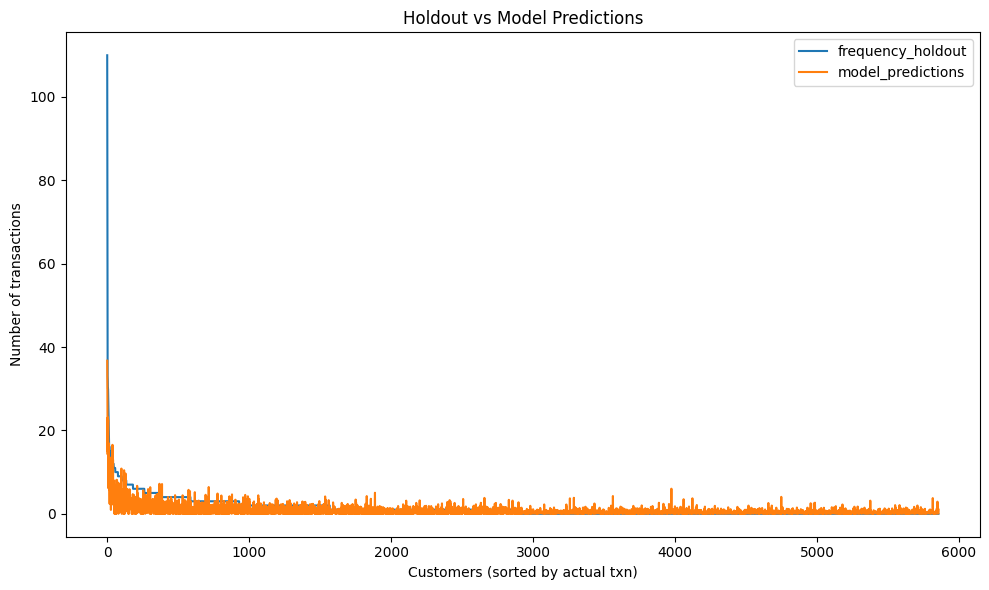

In [167]:
import matplotlib.pyplot as plt
import numpy as np

holdout_actual = (
    test_df.groupby("ID")["Invoice"].nunique()
    .rename("actual_txn_test") 
) #Series of realized transactions in Holdout period 

# 2) Model predictions
model_pred = final_df.set_index("ID")["pred_txn_90d"].rename("predicted")
display(model_pred.head(10))
# 3) Inxed = ID outer join of predicted and actual Series
compare_df = pd.concat([holdout_actual, model_pred], axis=1).fillna(0)

# 4) Sort by actual
compare_df = compare_df.sort_values("actual_txn_test", ascending=False)
#compare_df.head()

# 5) Plot
plt.figure(figsize=(10, 6))
plt.plot(compare_df["actual_txn_test"].values, label="frequency_holdout")
plt.plot(compare_df["predicted"].values, label="model_predictions")
plt.legend()
plt.xlabel("Customers (sorted by actual txn)")
plt.ylabel("Number of transactions")
plt.title("Holdout vs Model Predictions")
plt.tight_layout()
plt.show()





In [168]:
y_true = compare_df["actual_txn_test"].values
y_pred = compare_df["predicted"].values

mse = np.mean((y_true - y_pred) ** 2)
print("MSE is:",mse)

mae = np.mean(np.abs(y_true - y_pred))
print("MAE is:",mae) 


MSE is: 4.576265584147255
MAE is: 1.0340320958672045


#### 3.3.2 Gamma-Gamma Model Fit

Gamma-Gamma model to find E[Avarage Spending of a Customer]

In [ ]:
from lifetimes import GammaGammaFitter
#Finds avarage spending value per transaction for each customers 
ggf = GammaGammaFitter(penalizer_coef=0.01)

#Gamma-Gamma model
ggf.fit(
    final_df.loc[final_df["Freq"] > 0, "Freq"], #Frequency must be greater than 0
    final_df.loc[final_df["Freq"] > 0, "A_Total_S"] #Average spending for those frequency >0
)

#Fitting the Parameter to the model
final_df["exp_avg_spend"] = ggf.conditional_expected_average_profit(
    final_df["Freq"],
    final_df["A_Total_S"])

final_df.head(1)

#### 3.3.3 CLV Analysis



In [ ]:
final_df["CLV1"] = final_df["exp_avg_spend"] * final_df["pred_txn_90d"]*final_df["p_alive"] #Weighted with Probability Alive
final_df["CLV2"] = final_df["exp_avg_spend"] * final_df["pred_txn_90d"]#Weighted without probability alive
final_df.head()
